**Import Necessary Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

**Gaussian Filter for Denoising**

In [2]:
def apply_gaussian_filter(images):
    denoised_images = []
    for image in images:
        # Convert to uint8 for cv2 to process
        image_uint8 = (image * 255).astype(np.uint8)
        # Apply Gaussian filter
        denoised_image = cv2.GaussianBlur(image_uint8, (5, 5), sigmaX=1)
        # Normalize back to [0, 1]
        denoised_images.append(denoised_image / 255.0)
    return np.array(denoised_images)

**Display Last 5 Images: Low-Resolution, High-Resolution, and Super-Resolution**

In [3]:
def show_last_images(lr_images, hr_images, sr_images):
    indices = range(sr_images.shape[0] - 5, sr_images.shape[0])  # Select the last 5 indices
    plt.figure(figsize=(15, 5))  # Adjust the figure size for better visibility
    
    for i, idx in enumerate(indices):
        plt.subplot(3, 5, i + 1)
        plt.imshow(lr_images[idx])
        plt.title('Low-Res Image')
        plt.axis('off')

        plt.subplot(3, 5, i + 6)
        plt.imshow(hr_images[idx])
        plt.title('High-Res Image')
        plt.axis('off')

        plt.subplot(3, 5, i + 11)
        plt.imshow(sr_images[idx])
        plt.title('Super-Res Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

**Residual Dense Block with Attention**

In [4]:
def residual_dense_block(input_tensor, filters):
    x = input_tensor
    for _ in range(4):
        x = layers.Conv2D(filters, (3, 3), padding="same")(x)
        x = layers.LeakyReLU(0.2)(x)
        input_tensor = layers.Concatenate()([input_tensor, x])
    
    # Channel attention
    channel_attention = layers.GlobalAveragePooling2D()(x)
    channel_attention = layers.Dense(filters // 16, activation='relu')(channel_attention)
    channel_attention = layers.Dense(filters, activation='sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, filters))(channel_attention)
    x = layers.multiply([x, channel_attention])
    return x

**Generator Model**

In [5]:
def build_rdn_generator(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, (3, 3), padding="same")(inputs)
    
    # Residual dense blocks with attention
    for _ in range(6):  # 6 RDN blocks
        x = residual_dense_block(x, 64)
    
    # Upsample layers
    x = layers.Conv2D(256, (3, 3), padding="same")(x)
    x = layers.UpSampling2D(size=2)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(3, (3, 3), padding="same", activation="tanh")(x)

    return Model(inputs, x)

**Discriminator Model**

In [6]:
def build_discriminator(input_shape, identity_feature_shape):
    input_img = layers.Input(shape=input_shape)  # High-resolution input
    input_lr = layers.Input(shape=input_shape)   # Low-resolution input
    identity_features = layers.Input(shape=identity_feature_shape)  # Identity features (e.g., 4, 4, 512)
    
    # Resize identity features to match input shape
    resized_identity_features = layers.Reshape((input_shape[0], input_shape[1], -1))(identity_features)
    print(f"Shape of resized identity features: {resized_identity_features.shape}")
    
    # Concatenate inputs: high-resolution image, low-resolution image, and identity features
    concatenated = layers.Concatenate()([input_img, input_lr, resized_identity_features])
    print(f"Shape after concatenation: {concatenated.shape}")
    
    # Convolutional layers
    x = layers.Conv2D(64, (3, 3), padding="same")(concatenated)
    x = layers.LeakyReLU(0.2)(x)
    print(f"Shape after first Conv2D: {x.shape}")
    
    for i in range(4):
        x = layers.Conv2D(64 * (2 ** i), (3, 3), strides=2, padding="same")(x)
        x = layers.LeakyReLU(0.2)(x)
        print(f"Shape after Conv2D layer {i+1}: {x.shape}")
        
    output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
    print(f"Shape of final output: {output.shape}")
    
    return Model([input_img, input_lr, identity_features], output)

**Pre-trained Face Recognition Model to Extract Identity Features**

In [7]:
def build_identity_model(input_shape):
    base_model = VGG19(include_top=False, input_shape=input_shape)
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer("block5_conv4").output)
    return feature_extractor

**Perceptual Loss Function on Identity Features**

In [8]:
def perceptual_loss(hr_image, sr_image, identity_model):
    # Ensure images are properly sized before passing to the identity model
    hr_features = identity_model(hr_image, training=False)  # Pass HR image to identity model
    sr_features = identity_model(sr_image, training=False)  # Pass SR image to identity model
    return tf.reduce_mean(tf.square(hr_features - sr_features))

**Pixel-Wise Mean Squared Error (MSE) Loss**

In [9]:
def pixel_mse_loss(hr_image, sr_image): 
    return tf.reduce_mean(tf.square(hr_image - sr_image))

**Hinge Version of Adversarial Loss**

In [10]:
def adversarial_loss(disc_real, disc_fake):
    return tf.reduce_mean(tf.nn.relu(1.0 - disc_real)) + tf.reduce_mean(tf.nn.relu(1.0 + disc_fake))

**Data Preparation**

In [11]:
def prepare_data(batch_size=16, image_size=(32, 32), identity_size=(128, 128)):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # Create a generator for high-resolution images
    hr_data = datagen.flow_from_directory(
        r"C:\Users\shakib\Downloads\LFW_Dataset",
        target_size=image_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=True
    )
    
    while True:
        # Get next batch of HR images
        hr_images = hr_data.next()
        lr_images = hr_data.next()  

        # Denoise HR images before resizing for the identity model
        hr_images_denoised = apply_gaussian_filter(hr_images)
        
        # Yield both LR and resized HR images
        yield lr_images, hr_images_denoised 
    return lr_images, hr_images_denoised

**Training Procedure**

In [12]:
def train_spgan(generator_model, discriminator, identity_model, train_data, epochs=10, steps_per_epoch=25):
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        for step in range(steps_per_epoch):
            try:
                # Get the next batch of low-resolution and high-resolution images
                lr_images, hr_images = next(train_data)  # Ensure this yields correctly shaped batches

                # Check if the batch size is less than 5
                if lr_images.shape[0] < 5 or hr_images.shape[0] < 5:
                    
                    continue  # Skip the rest of the loop and proceed to the next batch

                lr_img = tf.image.resize(hr_images, (16, 16))  # Resize for LR

                # Generate super-resolution images using the low-resolution input
                sr_images = generator_model(lr_img, training=True)

                # Upsample identity features if necessary
                hr_identity_features_resized = tf.image.resize(identity_model(hr_images), (128, 128))
                sr_identity_features_resized = tf.image.resize(identity_model(sr_images), (128, 128))

                # Train the discriminator
                with tf.GradientTape() as disc_tape:
                    real_output = discriminator([hr_images, lr_images, hr_identity_features_resized])  
                    fake_output = discriminator([sr_images, lr_images, sr_identity_features_resized])  

                    disc_loss = adversarial_loss(real_output, fake_output)

                disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
                disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

                # Train the generator
                with tf.GradientTape() as gen_tape:
                    sr_images = generator_model(lr_img, training=True)  
                    
                    # Calculate perceptual and pixel-wise losses
                    perc_loss = perceptual_loss(hr_images, sr_images, identity_model)
                    pixel_loss = pixel_mse_loss(hr_images, sr_images)  

                    # Generator loss includes perceptual loss and pixel-wise loss
                    gen_loss = perc_loss + pixel_loss - tf.reduce_mean(fake_output)

                gen_gradients = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
                gen_optimizer.apply_gradients(zip(gen_gradients, generator_model.trainable_variables))

            except StopIteration:
                print("Data iterator has been exhausted.")
                break

        print(f" - Generator Loss: {gen_loss.numpy()} - Discriminator Loss: {disc_loss.numpy()}")

**Instantiate Models**

In [13]:
input_shape = (16, 16, 3)  # LR image shape
identity_feature_shape = (128, 128, 512)  # Identity feature shape after VGG19

generator = build_rdn_generator(input_shape)
discriminator = build_discriminator((32, 32, 3), identity_feature_shape)
identity_model = build_identity_model((32, 32, 3))

Shape of resized identity features: (None, 32, 32, 8192)
Shape after concatenation: (None, 32, 32, 8198)
Shape after first Conv2D: (None, 32, 32, 64)
Shape after Conv2D layer 1: (None, 16, 16, 64)
Shape after Conv2D layer 2: (None, 8, 8, 128)
Shape after Conv2D layer 3: (None, 4, 4, 256)
Shape after Conv2D layer 4: (None, 2, 2, 512)
Shape of final output: (None, 2, 2, 1)


**Prepare Training Data**

In [14]:
train_data = prepare_data(batch_size=5, image_size=(32, 32))

**Train SPGAN**

In [15]:
train_spgan(generator, discriminator, identity_model, train_data, epochs=10, steps_per_epoch=15)

Epoch 1/10
Found 156 images belonging to 80 classes.
 - Generator Loss: 0.14106668531894684 - Discriminator Loss: 1.0
Epoch 2/10
 - Generator Loss: 0.12314727902412415 - Discriminator Loss: 1.00002121925354
Epoch 3/10
 - Generator Loss: 0.14371521770954132 - Discriminator Loss: 1.0000059604644775
Epoch 4/10
 - Generator Loss: 0.14715984463691711 - Discriminator Loss: 1.0000004768371582
Epoch 5/10
 - Generator Loss: 0.13865917921066284 - Discriminator Loss: 1.0001510381698608
Epoch 6/10
 - Generator Loss: 0.10326960682868958 - Discriminator Loss: 1.000009536743164
Epoch 7/10
 - Generator Loss: 0.08086633682250977 - Discriminator Loss: 2.0
Epoch 8/10
 - Generator Loss: 0.08189079165458679 - Discriminator Loss: 2.0
Epoch 9/10
 - Generator Loss: 0.06868983060121536 - Discriminator Loss: 2.0
Epoch 10/10
 - Generator Loss: 0.056599050760269165 - Discriminator Loss: 2.0


**Accuracy**

In [16]:
def face_recognition_accuracy(generator, identity_model, test_data, threshold=0.5, num_batches=100):
    correct = 0
    total = 0
    
    # Start tracking time
    start_time = time.time()

    for batch in range(num_batches):
        lr_images, hr_images = next(test_data)  # Use next to get the batch
        
        # Check if the batch size is less than 5
        if lr_images.shape[0] < 5 or hr_images.shape[0] < 5:
            continue
        
        lr_img = tf.image.resize(lr_images, (16, 16)) 
        # Generate super-resolved images
        sr_images = generator.predict(lr_img)
        
        # Extract identity features from HR and SR images
        hr_identity_features = identity_model.predict(hr_images)
        sr_identity_features = identity_model.predict(sr_images)
        
        # Calculate cosine similarity
        similarity_scores = cosine_similarity(
            hr_identity_features.reshape(len(hr_images), -1),
            sr_identity_features.reshape(len(sr_images), -1)
        )
        
        # Count correct predictions
        for score in similarity_scores:
            # Check if any score in the row is above the threshold
            if np.any(score >= threshold):
                correct += 1
                
        total += len(hr_images)

        # Print progress every 10 batches
        if batch % 10 == 0:
            elapsed_time = time.time() - start_time
            estimated_time = (elapsed_time / (batch + 1)) * (num_batches - (batch + 1))
            print(f"Processed {total} images, estimated time remaining: {estimated_time:.2f} seconds")

        # Show last 5 images from the batch
        if batch % 5 == 0:  # Display every 5 batches
            show_last_images(lr_images, hr_images, sr_images)

    accuracy = correct / total if total > 0 else 0  # Avoid division by zero
    print(f"Face Recognition Accuracy: {accuracy * 100:.2f}%")
    return accuracy

**Prepare Test Data**

In [17]:
test_data = prepare_data(batch_size=5, image_size=(32, 32))

**Evaluate Face Recognition Accuracy**

Found 156 images belonging to 80 classes.
Processed 5 images, estimated time remaining: 81.61 seconds


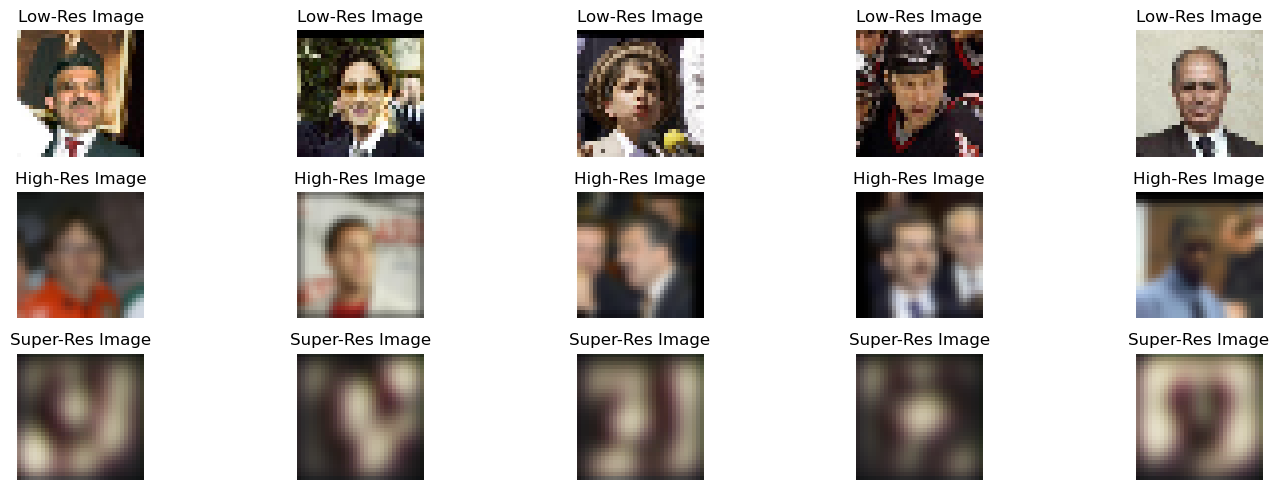

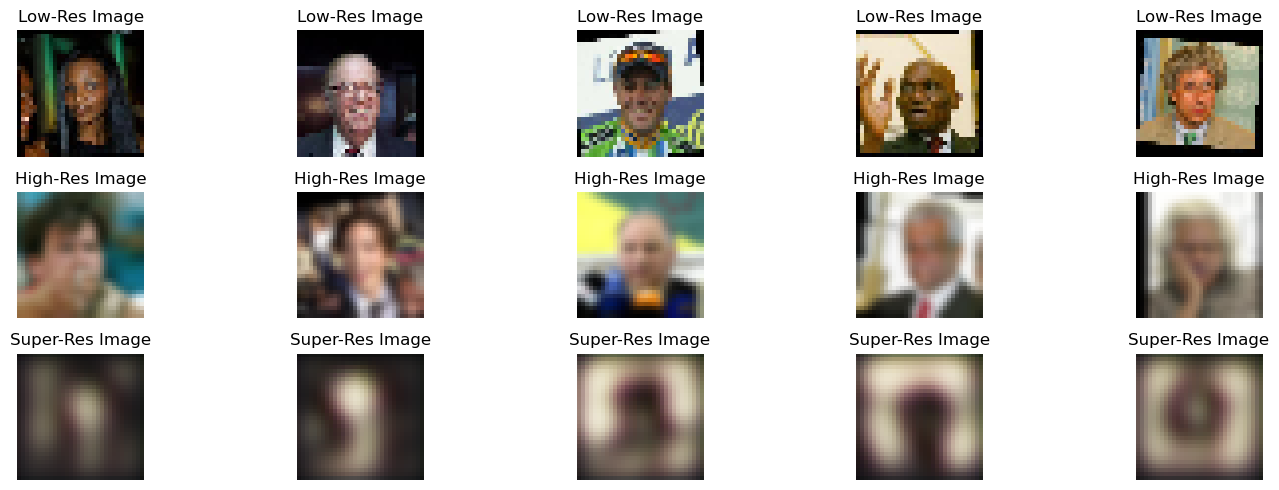

Processed 55 images, estimated time remaining: 22.85 seconds


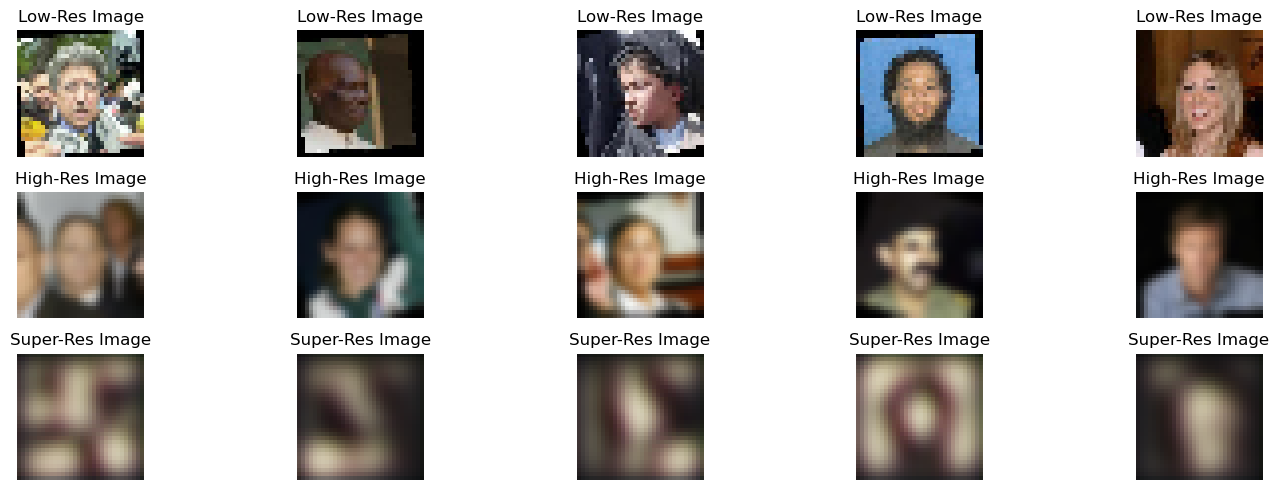

Processed 100 images, estimated time remaining: 16.55 seconds


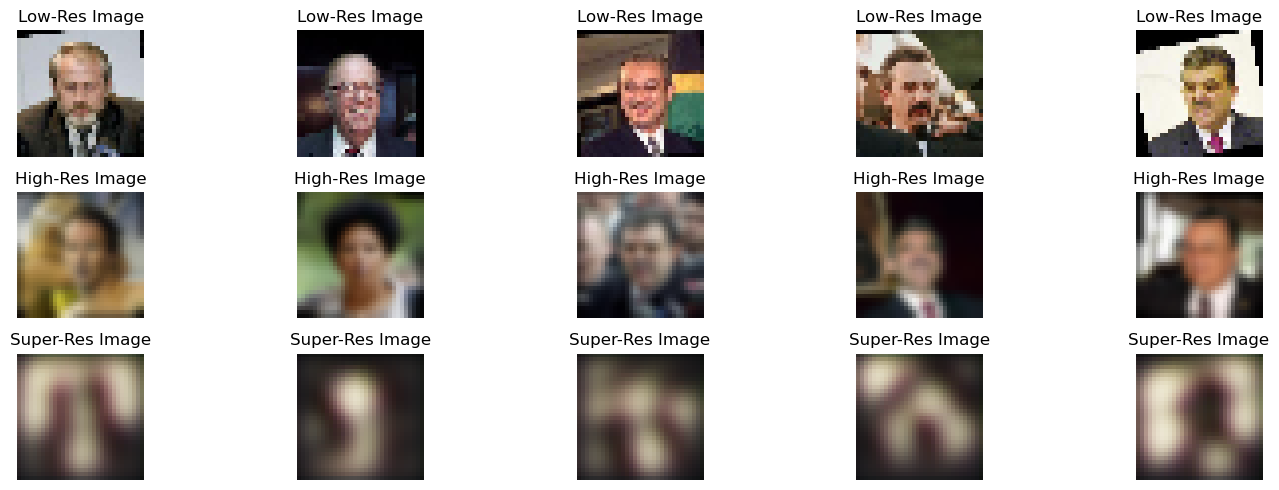

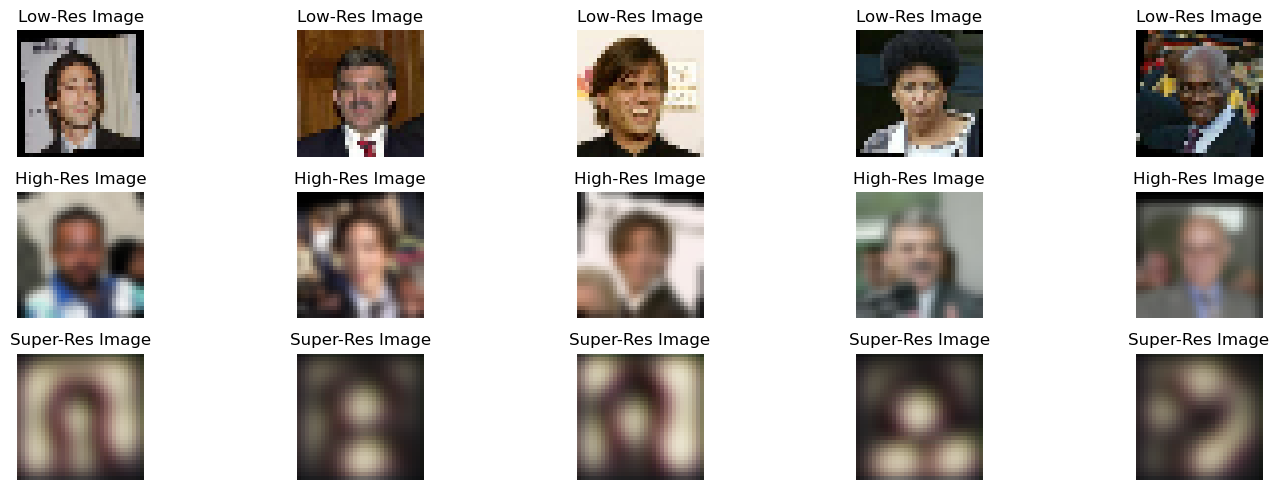

Processed 150 images, estimated time remaining: 15.33 seconds


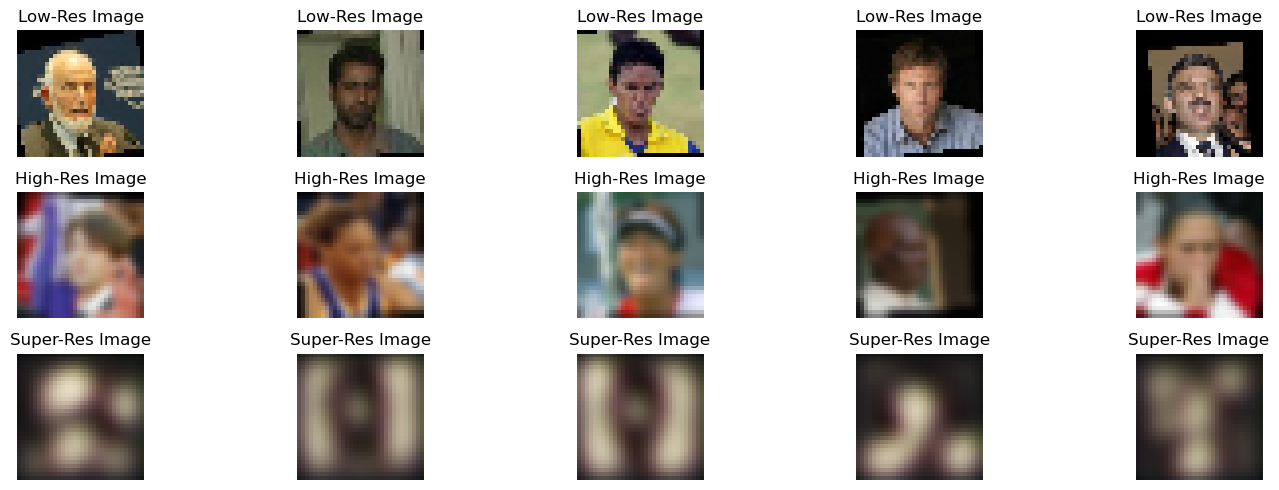

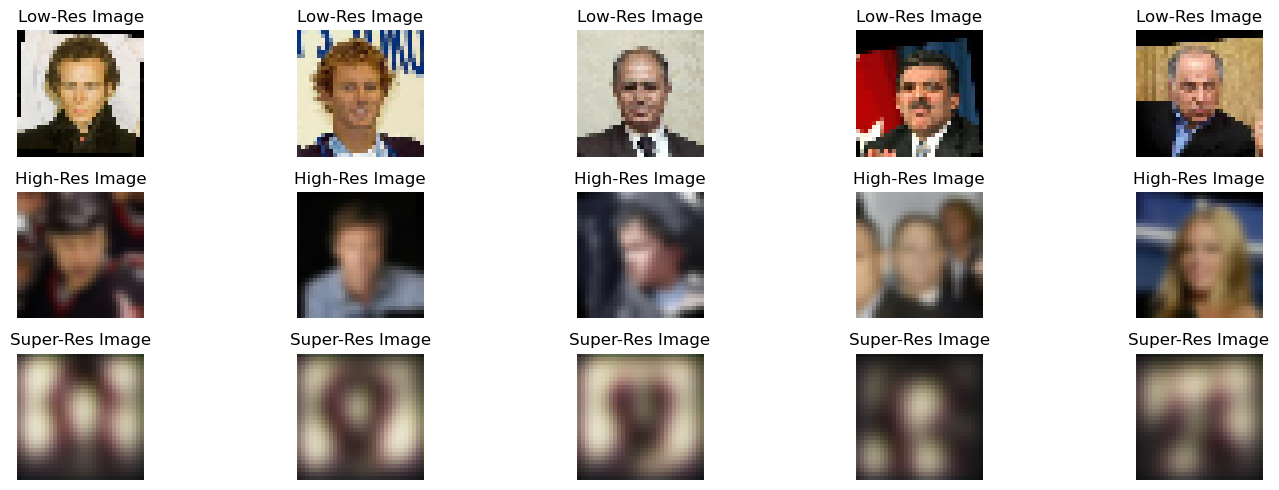

Processed 195 images, estimated time remaining: 13.51 seconds


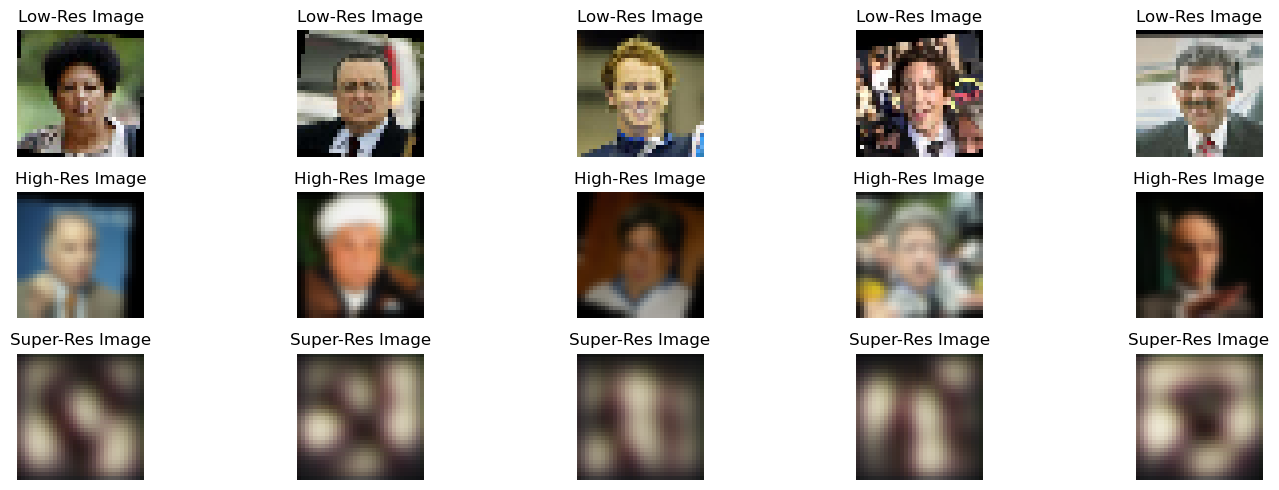

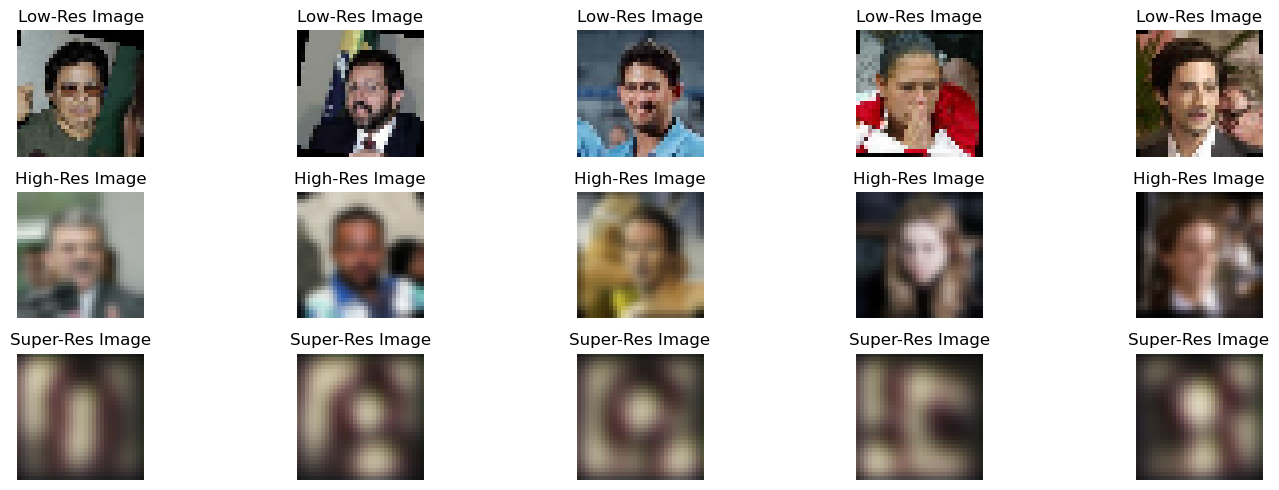

Processed 240 images, estimated time remaining: 11.18 seconds


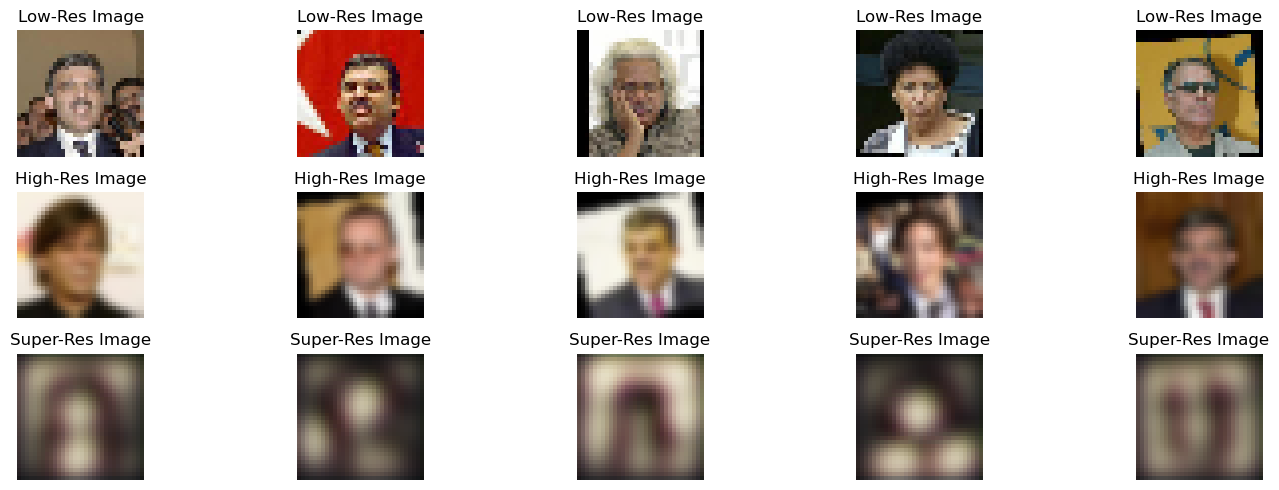

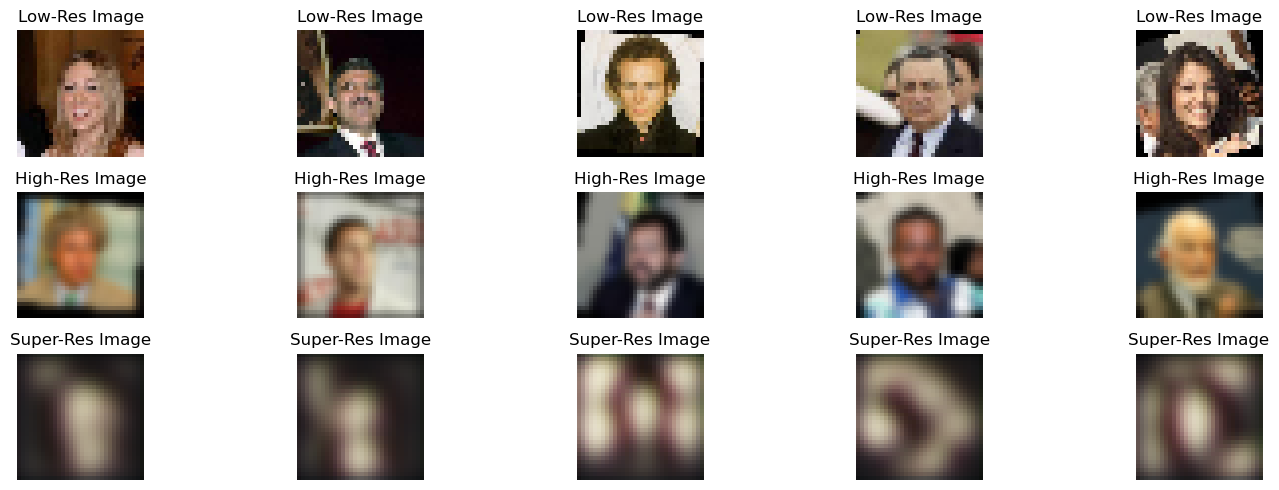

Processed 290 images, estimated time remaining: 9.10 seconds


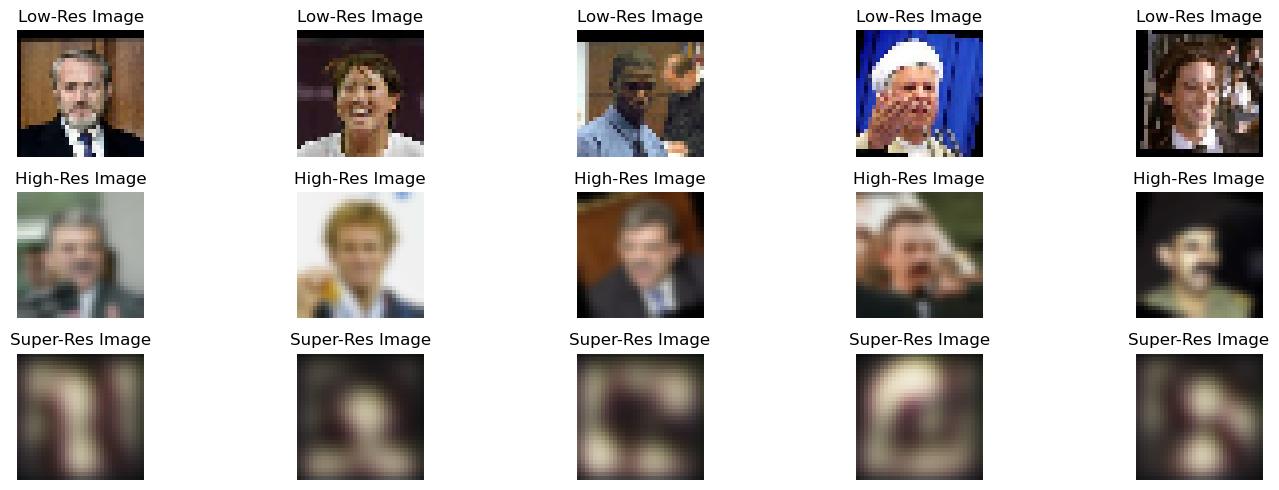

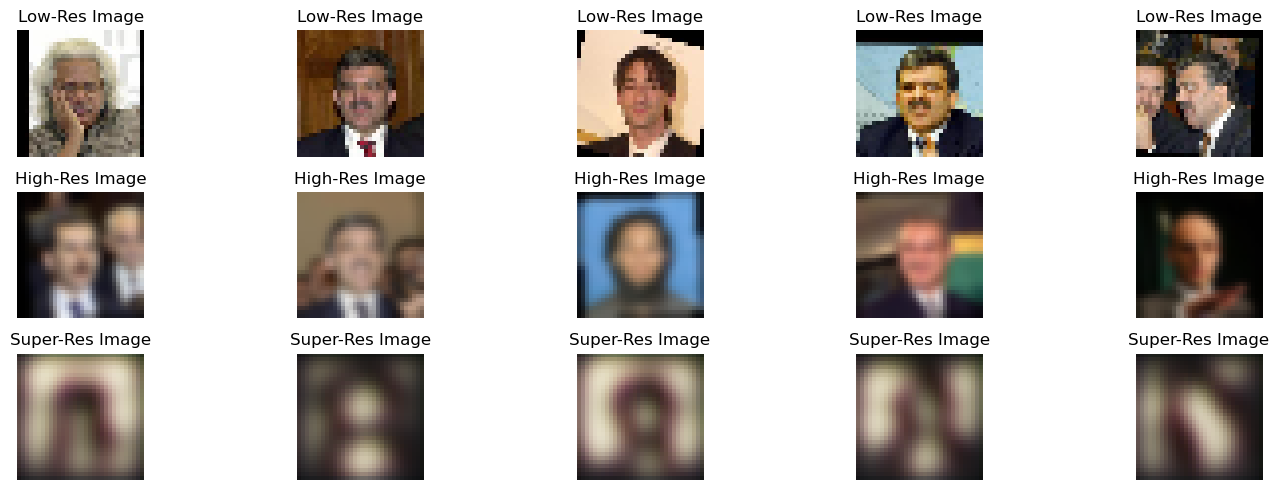

Processed 335 images, estimated time remaining: 6.75 seconds


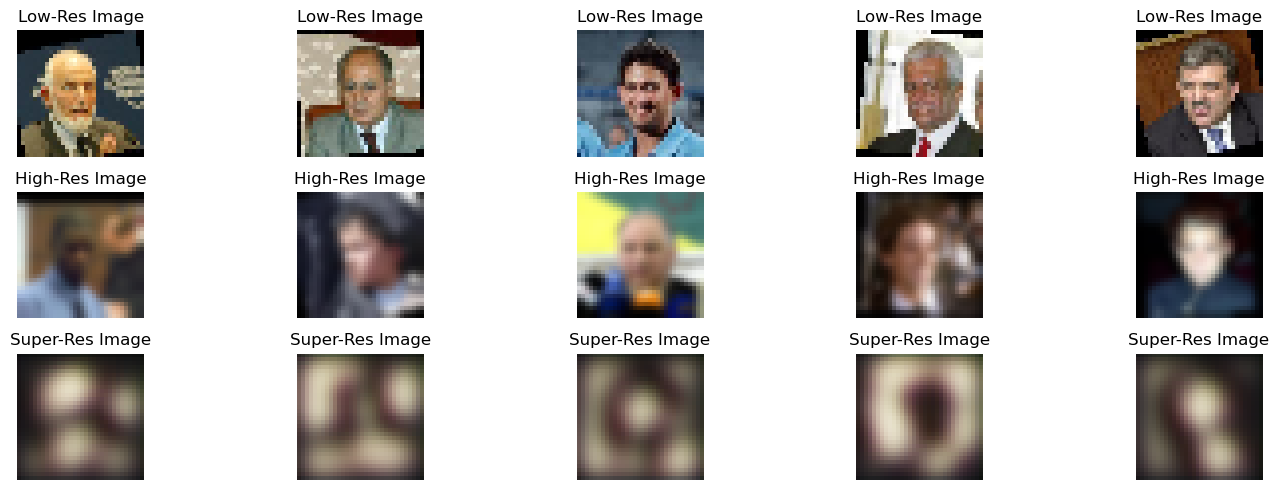

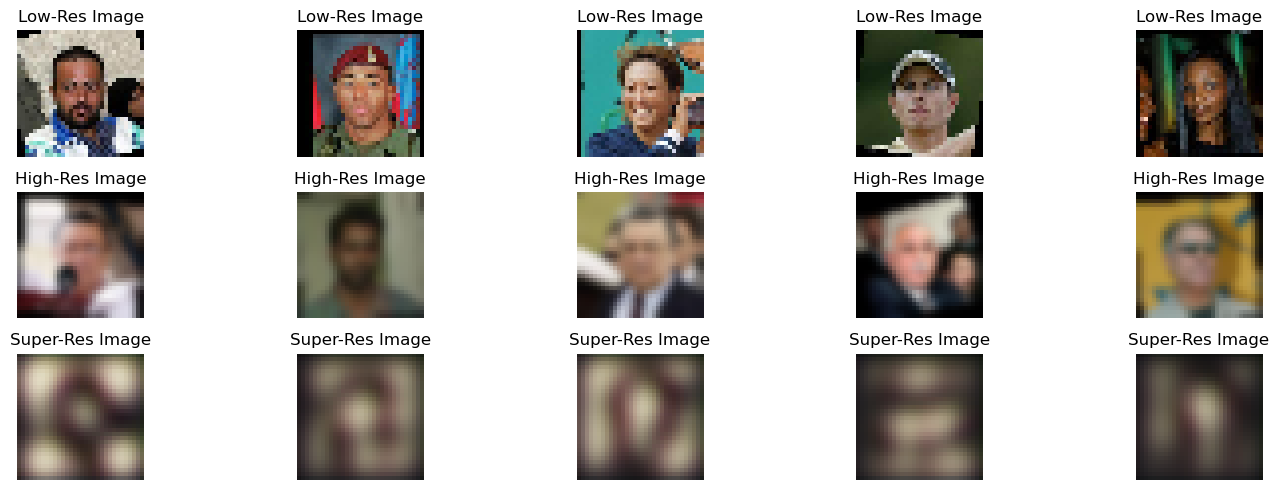

Processed 380 images, estimated time remaining: 4.44 seconds


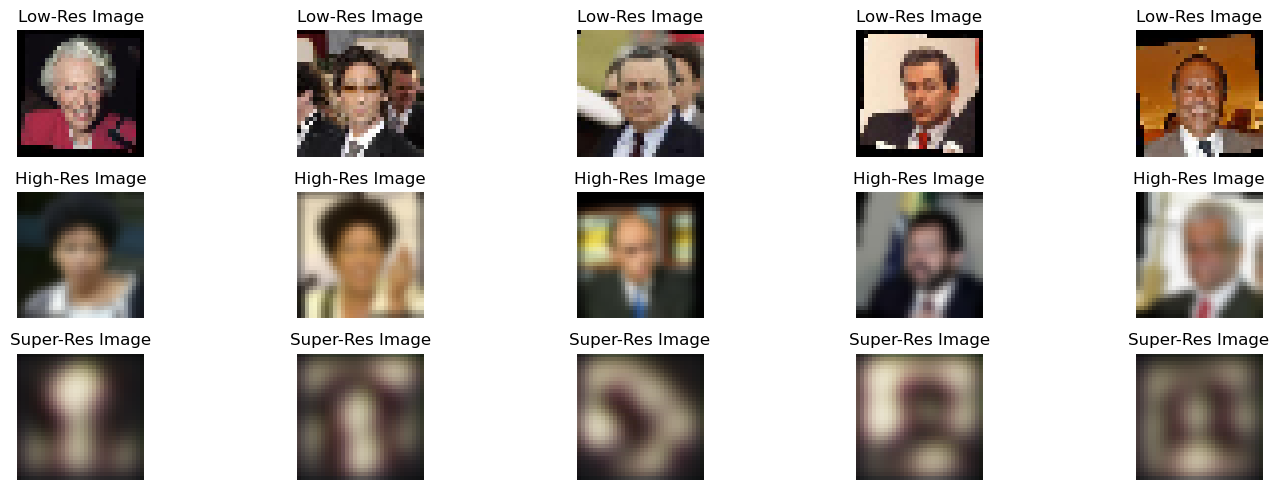

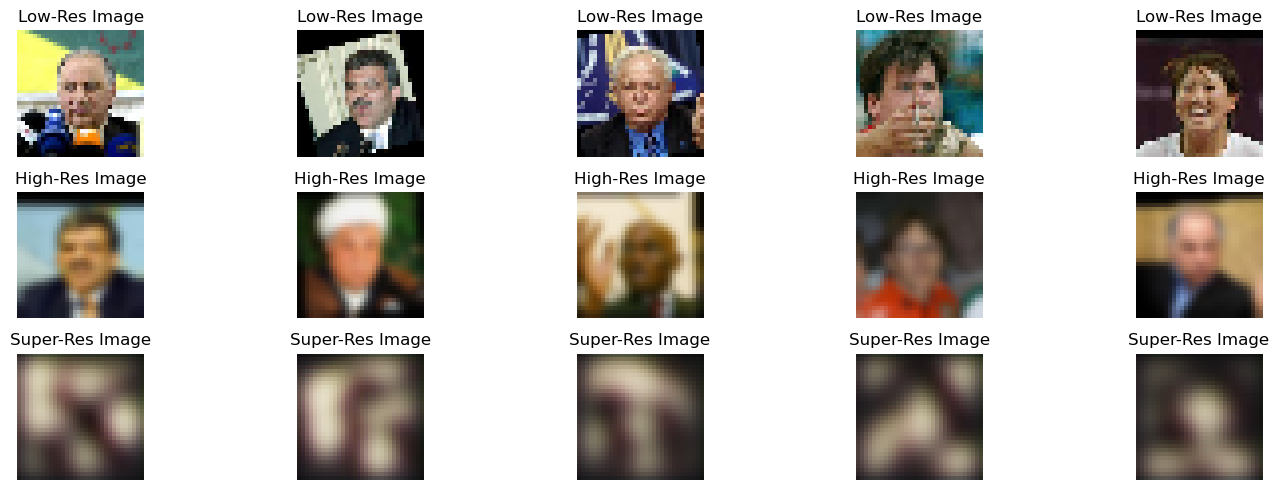

Processed 430 images, estimated time remaining: 2.11 seconds


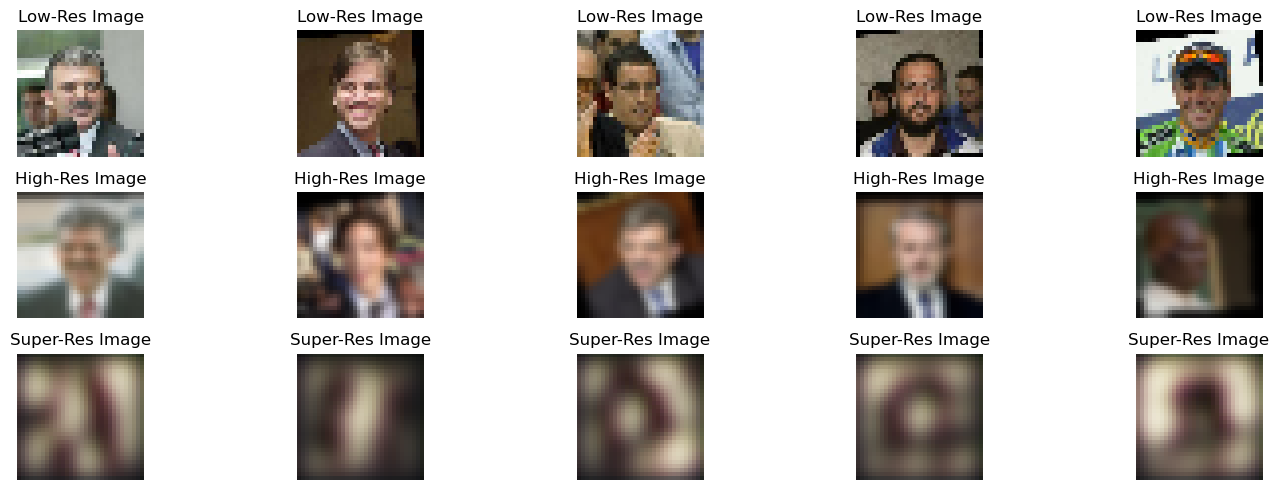

Face Recognition Accuracy: 100.00%


1.0

In [18]:
face_recognition_accuracy(generator, identity_model, test_data, threshold=0.5, num_batches=100)